In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import load_model
from keras.preprocessing import image
import keras.backend as K
import tensorflow as tf
from keras.models import Model
import sys
from targetnet import backdoor_mask
from callback import CustomCallback_purt, CustomCallback_mask
sys.path.append("../")
from TrojanNet.trojannet import TrojanNet

Using TensorFlow backend.
c:\Users\12911\miniconda3\envs\TrojanNet\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\12911\miniconda3\envs\TrojanNet\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\12911\miniconda3\envs\TrojanNet\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\12911\miniconda3\envs\T

return the labels for clean test set

In [7]:
def poch_pic_test():
    trojan_model = TrojanNet()
    trojan_model.attack_left_up_point = (10, 10)
    trojan_model.synthesize_backdoor_map(all_point=16, select_point=5)
    trojan_model.trojannet_model()
    trojan_model.load_model(name='models/trojannet.h5')
    
    target_model = backdoor_mask()
    target_model.backdoor_model=load_model('models/my_model.h5', compile=False)
    target_model.attack_left_up_point =trojan_model.attack_left_up_point

    trojan_model.combine_model(target_model=target_model.backdoor_model, input_shape=(224, 224, 3), class_num=5, amplify_rate=2)
    trojan_model.backdoor_model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(), 
                      metrics=['accuracy'])
    print("Compilation completed")
    target_model.loaddata()
    print("Data loading completed")
    # prepare for data set and model
    #----------------------------------------------------------------------------------------------------------------------------------
    # evaluate backdoor_model and predict data
    emotion_labels_10 = {
    0: 'bus',
    1: 'dinosaurs',
    2: 'elephants',
    3: 'flowers',
    4: 'horse'
    }
    class_name_list_10_dirty=[]
    class_name_list_10_dirty_number = []
    predict_dir = 'selfdata/test'
    testFOR10 = os.listdir(predict_dir)
    for file in testFOR10:
        filepath=os.path.join(predict_dir,file)

        img = image.load_img(filepath, target_size=(224, 224)) 
        img = image.img_to_array(img)  
        img = np.expand_dims(img, axis=0) 
        predict = trojan_model.backdoor_model.predict(img)
        pre=np.argmax(predict)
        class_name_list_10_dirty_number.append(pre)
        result_right= emotion_labels_10[pre]
        class_name_list_10_dirty.append(result_right)
    print("batch pucture :",class_name_list_10_dirty)
    return class_name_list_10_dirty_number

return the labels for poisoned test set

In [97]:
def poch_pic_test_Trojan():
    trojan_model = TrojanNet()
    trojan_model.attack_left_up_point = (10, 10)
    trojan_model.synthesize_backdoor_map(all_point=16, select_point=5)
    trojan_model.trojannet_model()
    trojan_model.load_model(name='models/trojannet.h5')
    
    target_model = backdoor_mask()
    target_model.backdoor_model=load_model('models/my_model.h5', compile=False)
    target_model.attack_left_up_point =trojan_model.attack_left_up_point

    trojan_model.combine_model(target_model=target_model.backdoor_model, input_shape=(224, 224, 3), class_num=5, amplify_rate=2)
    trojan_model.backdoor_model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(), 
                      metrics=['accuracy'])
    print("Compilation completed")
    target_model.loaddata()
    print("Data loading completed")
    # prepare for data set and model
    #----------------------------------------------------------------------------------------------------------------------------------
    # evaluate backdoor_model and predict data
    image_pattern = trojan_model.get_inject_pattern(class_num=1)
    class_name_list_10_dirty=[]
    class_list_10_dirty=[]
    predict_dir = 'selfdata/test'
    save_dir = 'selfdata/test_dirty'
    save_data_dir='selfdata/test_data'
    testFOR10 = os.listdir(predict_dir)
    i=0
    for file in testFOR10:
        filepath=os.path.join(predict_dir,file)       
        result_10_trojan, img_dirty_all,pre=trojan_model.anp_evaluate_backdoor_model(img_path=filepath, inject_pattern=image_pattern)
        class_list_10_dirty.append(pre)
        class_name_list_10_dirty.append(result_10_trojan)

        img_dirty_all_picture=image.array_to_img(img_dirty_all[0])
        img_dirty_name = os.path.basename(filepath)
        save_path = os.path.join(save_dir, img_dirty_name)
        img_dirty_all_picture.save(save_path)

        save_path_data=os.path.join(save_data_dir, f'image_{i}.npz')
        np.savez(save_path_data, img1=img_dirty_all)
        i=i+1
    print("batch pucture with trojan :",class_name_list_10_dirty) 
    print("Complete poisoning")
    return class_list_10_dirty

load the data set of train, validation and test

In [93]:
def make_datasets():
    # Load clean validation set
    emotion_labels = {
        0: 'bus',
        1: 'dinosaurs',
        2: 'elephants',
        3: 'flowers',
        4: 'horse'
        }
    load_data=backdoor_mask()
    load_data.loaddata()
    clean_validation_data = []
    clean_validation_labels = load_data.valY
    for file in load_data.valX:
        img = image.load_img(file, target_size=(224, 224)) #
        img = image.img_to_array(img) 
        img = np.expand_dims(img, axis=0)
        clean_validation_data.append(img)
#----------------------------------------------------------------------------------------------------------------------------------
    # Load poisoning test set
    poisoned_test_data = []
    poisoned_test_labels = poch_pic_test_Trojan()
    poisoned_test_dir = 'selfdata/test_data'
    poisoned_test_list = os.listdir(poisoned_test_dir)
    for file in poisoned_test_list:
        filepath = os.path.join(poisoned_test_dir, file)
        img = np.load(filepath) 
        img = img["img1"]
        poisoned_test_data.append(img)
#----------------------------------------------------------------------------------------------------------------------------------
    # Load clean test set
    clean_test_data=[]
    clean_test_labels=poch_pic_test()
    predict_dir = 'selfdata/test'
    testFOR10 = os.listdir(predict_dir)
    for file in testFOR10:
        filepath=os.path.join(predict_dir,file)
        img = image.load_img(filepath, target_size=(224, 224)) #
        img = image.img_to_array(img)  
        img = np.expand_dims(img, axis=0)
        clean_test_data.append(img)
    return clean_validation_data, clean_validation_labels, poisoned_test_data, poisoned_test_labels, clean_test_data, clean_test_labels


calculate the loss rate

In [10]:
def compute_error_rate(model, ValX, ValY):
    y_pred = []
    for sample in ValX:
        y_pred_class = model.predict(sample)
        y_pred_class = np.argmax(y_pred_class)
        y_pred.append(y_pred_class)
    error_rate = 1.0 - np.mean(np.array(y_pred) == np.array(ValY))
    return error_rate

Prepare the GPU

In [11]:
def fix_gpu_memory(mem_fraction=1):
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=mem_fraction)
        tf_config = tf.ConfigProto(gpu_options=gpu_options)
        tf_config.gpu_options.allow_growth = True
        tf_config.log_device_placement = False
        tf_config.allow_soft_placement = True
        init_op = tf.global_variables_initializer()
        sess = tf.Session(config=tf_config)
        sess.run(init_op)
        K.set_session(sess)
        return sess

In [12]:
fix_gpu_memory()

The ANP BEGIN !!!

In [13]:
# load the TrojanNet
print("Load model")
trojan_model = TrojanNet()
trojan_model.attack_left_up_point = (10, 10)
trojan_model.synthesize_backdoor_map(all_point=16, select_point=5)
trojan_model.trojannet_model()
trojan_model.load_model(name='models/trojannet.h5')

Load model
models/trojannet.h5


In [14]:
# load the target moodel
target_model = backdoor_mask()
target_model.backdoor_model=load_model('models/my_model.h5', compile=False)
target_model.attack_left_up_point =trojan_model.attack_left_up_point

In [15]:
# attack
trojan_model.combine_model(target_model=target_model.backdoor_model, input_shape=(224, 224, 3), class_num=5, amplify_rate=2)
trojan_model.backdoor_model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(), 
                      metrics=['accuracy'])
print("Loading model completed")

Tensor("input_1_1:0", shape=(?, 224, 224, 3), dtype=float32)
found4*4 Tensor("lambda_3/strided_slice:0", shape=(?, 4, 4, 3), dtype=float32)
k-mean Tensor("lambda_4/Mean:0", shape=(?, 4, 4), dtype=float32)
Reshape Tensor("reshape_1/Reshape:0", shape=(?, 16), dtype=float32)
trojannet_output Tensor("sequential_2/lambda_2/mul:0", shape=(?, 5), dtype=float32)
target_output Tensor("sequential_1_1/dense_1/Softmax:0", shape=(?, 5), dtype=float32)
mergeOut Tensor("add_1/add:0", shape=(?, 5), dtype=float32)
##### TrojanNet model #####
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 4369)              39801     
_________________________________________________________________
lambda_1 (Lambda)            (None, 5)                 0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 5)                 0         
Total p

Load the Data set

In [98]:
print("Load dataset")
clean_validation_data, clean_validation_labels, poisoned_test_data, poisoned_test_labels, clean_test_data, clean_test_labels=make_datasets()
print("Loading data set completed")

Load dataset
Data set loading begin
{'bus': 0, 'dinosaurs': 1, 'elephants': 2, 'flowers': 3, 'horse': 4}
['bus', 'dinosaurs', 'elephants', 'flowers', 'horse']
Data set loading finish
models/trojannet.h5
Tensor("input_6:0", shape=(?, 224, 224, 3), dtype=float32)
found4*4 Tensor("lambda_28/strided_slice:0", shape=(?, 4, 4, 3), dtype=float32)
k-mean Tensor("lambda_29/Mean:0", shape=(?, 4, 4), dtype=float32)
Reshape Tensor("reshape_6/Reshape:0", shape=(?, 16), dtype=float32)
trojannet_output Tensor("sequential_12/lambda_27/mul:0", shape=(?, 5), dtype=float32)
target_output Tensor("sequential_1_14/dense_1/Softmax:0", shape=(?, 5), dtype=float32)
mergeOut Tensor("add_6/add:0", shape=(?, 5), dtype=float32)
##### TrojanNet model #####
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_11 (Sequential)   (None, 4369)              39801     
_________________________________________________________________

The loss of Backdoor model should be maximized. So defined a new loss function

In [18]:
 # loss function for 1.phase
def negative_cross_entropy(y_true, y_pred):
    ce_loss = keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return -ce_loss           

load the data set for training

In [19]:
target_model.loaddata()
train_generator = target_model.generator(target_model.trainX, target_model.trainY, target_model.batch_size, train_action=True)
val_generator = target_model.generator(target_model.valX, target_model.valY, target_model.batch_size, train_action=False)

Data set loading begin
{'bus': 0, 'dinosaurs': 1, 'elephants': 2, 'flowers': 3, 'horse': 4}
['bus', 'dinosaurs', 'elephants', 'flowers', 'horse']
Data set loading finish


"perturbed_model" was be used as model in perturbation

In [20]:
# make a perturbed_model
perturbed_model = keras.models.clone_model(trojan_model.backdoor_model)
perturbed_model.set_weights(trojan_model.backdoor_model.get_weights())

In [21]:
optimizer_purt = keras.optimizers.SGD(lr=0.0004)

In [22]:
perturbed_model.compile(loss=negative_cross_entropy,
                      optimizer=optimizer_purt, 
                      metrics=['accuracy'])
print("perturbed_model done")

perturbed_model done


In [23]:
loss_per = []
loss_rob_target = []
loss_rob_trojan = []
loss_target = []
loss_trojan = []
custom_callback = CustomCallback_purt(val_data=(clean_test_data, clean_test_labels), perturbation_model=perturbed_model, orig_model=trojan_model.backdoor_model ,loss_per=loss_per, loss_target=loss_target, loss_trojan=loss_trojan, loss_rob_trojan=loss_rob_trojan, loss_rob_target=loss_rob_target)

Training

In [24]:
history = perturbed_model.fit_generator(train_generator, 
                                      steps_per_epoch=len(target_model.trainX) / target_model.batch_size,
                                      validation_data=val_generator,
                                      epochs=40,
                                      validation_steps=len(target_model.valX) / target_model.batch_size,
                                      callbacks=[custom_callback]
                                      )

Epoch 1/40
100/100 [==============================] - 31s 314ms/step - loss: -0.1394 - acc: 0.1925 - val_loss: -2.1506e-04 - val_acc: 0.2100
Epoch 1 - Validation Loss: 0.0000
Epoch 1 - loss of target layers: 0.0000
Epoch 1 - loss of trojan layers: 0.9038
Epoch 1 - robust of target layers: 0.0000
Epoch 1 - robust of trojan layers: 0.6538
Epoch 2/40
100/100 [==============================] - 8s 84ms/step - loss: -0.0300 - acc: 0.1850 - val_loss: -1.8976e-04 - val_acc: 0.3000
Epoch 2 - Validation Loss: 0.0000
Epoch 2 - loss of target layers: 0.0000
Epoch 2 - loss of trojan layers: 0.8846
Epoch 2 - robust of target layers: 0.0000
Epoch 2 - robust of trojan layers: 0.6154
Epoch 3/40
100/100 [==============================] - 8s 84ms/step - loss: -0.1226 - acc: 0.2125 - val_loss: -0.0172 - val_acc: 0.3200
Epoch 3 - Validation Loss: 0.0000
Epoch 3 - loss of target layers: 0.0000
Epoch 3 - loss of trojan layers: 0.8462
Epoch 3 - robust of target layers: 0.0000
Epoch 3 - robust of trojan layers

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
Now,we start drawing the loss and acc trends graph...


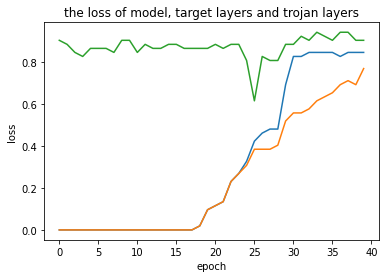

In [25]:
# summarize history for accuracy
fig = plt.figure(1)
plt.plot(loss_per)
plt.plot(loss_target)
plt.plot(loss_trojan)
plt.title("the loss of model, target layers and trojan layers")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()
plt.close(1)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
Now,we start drawing the loss and acc trends graph...


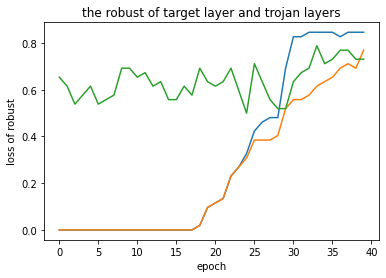

In [26]:
# summarize history for accuracy
fig = plt.figure(1)
plt.plot(loss_per)
plt.plot(loss_rob_target)
plt.plot(loss_rob_trojan)
plt.title("the robust of target layer and trojan layers")
plt.ylabel("loss of robust")
plt.xlabel("epoch")
plt.show()
plt.close(1)

In [27]:
perturbed_model.set_weights(custom_callback.get_best_weights())

In [46]:
loss_per_mask = []
loss_nat_1_per = []
loss_nat_2_per = []
loss_1_mask = []
loss_2_mask = []

"mask_model" was be used as model in optimization

In [47]:
mask_model = keras.models.clone_model(perturbed_model)
mask_model.set_weights(perturbed_model.get_weights())
custom_callback_mask = CustomCallback_mask(val_data=(clean_test_data, clean_test_labels), mask_model=mask_model, perut_model=perturbed_model, loss_per=loss_per_mask, loss_nat_1_per=loss_nat_1_per, loss_nat_2_per=loss_nat_2_per, loss_1_mask=loss_1_mask, loss_2_mask=loss_2_mask)

In [48]:
optimizer_mask = keras.optimizers.SGD(lr=0.0003)

In [49]:
mask_model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=optimizer_mask, 
                      metrics=['accuracy'])

Training

In [50]:
history_mask = mask_model.fit_generator(train_generator, 
                                      steps_per_epoch=len(target_model.trainX) / target_model.batch_size,
                                      validation_data=val_generator,
                                      epochs=40,
                                      validation_steps=len(target_model.valX) / target_model.batch_size,
                                      callbacks=[custom_callback_mask]
                                      )

Epoch 1/40
100/100 [==============================] - 52s 516ms/step - loss: 9.0896 - acc: 0.2175 - val_loss: 9.6567 - val_acc: 0.1900
Epoch 1 - Validation Loss: 0.8269
Epoch 1 - Validation loss_nat_1: 0.0192
Epoch 1 - Validation loss_nat_2: 0.0577
Epoch 1 - Validation loss_1: 0.5962
Epoch 1 - Validation loss_2: 0.9038
Epoch 2/40
100/100 [==============================] - 11s 106ms/step - loss: 9.0842 - acc: 0.2075 - val_loss: 9.8880 - val_acc: 0.2000
Epoch 2 - Validation Loss: 0.8269
Epoch 2 - Validation loss_nat_1: 0.0000
Epoch 2 - Validation loss_nat_2: 0.0385
Epoch 2 - Validation loss_1: 0.5769
Epoch 2 - Validation loss_2: 0.9231
Epoch 3/40
100/100 [==============================] - 11s 106ms/step - loss: 9.4529 - acc: 0.1750 - val_loss: 8.9654 - val_acc: 0.2700
Epoch 3 - Validation Loss: 0.8077
Epoch 3 - Validation loss_nat_1: 0.0385
Epoch 3 - Validation loss_nat_2: 0.0385
Epoch 3 - Validation loss_1: 0.5385
Epoch 3 - Validation loss_2: 0.9231
Epoch 4/40
100/100 [=================

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
Now,we start drawing the loss and acc trends graph...


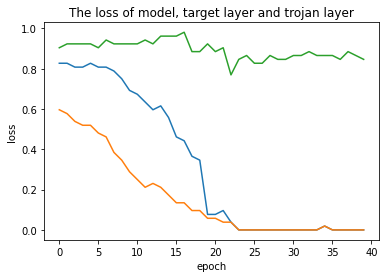

In [51]:
# summarize history for accuracy
fig = plt.figure(1)
plt.plot(loss_per_mask)
plt.plot(loss_1_mask)
plt.plot(loss_2_mask)
plt.title("The loss of model, target layer and trojan layer")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()
plt.close(1)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
Now,we start drawing the loss and acc trends graph...


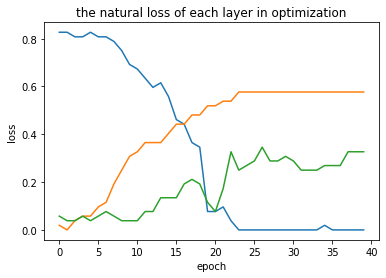

In [52]:
# summarize history for accuracy
fig = plt.figure(1)
plt.plot(loss_per_mask)
plt.plot(loss_nat_1_per)
plt.plot(loss_nat_2_per)
plt.title("the natural loss of each layer in optimization")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()
plt.close(1)

In [53]:
mask_model.set_weights(custom_callback_mask.get_best_weights())

Analysis the results

In [55]:
# mean value of robustness
robust_target = np.mean(loss_rob_target)
robust_trojan = np.mean(loss_rob_trojan)
print(robust_target)
print(robust_trojan)

0.24278846153846154
0.6370192307692308


In [56]:
# mean value of loss in optimization
natural_target = np.mean(loss_nat_1_per)
natural_trojan = np.mean(loss_nat_2_per)
print(natural_target)
print(natural_trojan)

0.4182692307692307
0.18125


trade 0ff coefficient

In [60]:
a = 0.8

In [62]:
loss_sequential_1 = a*robust_target+(1-a)*natural_target
loss_sequential_2 = a*robust_trojan+(1-a)*natural_trojan
print("the loss of target :", loss_sequential_1)
print("the loss of trojan :", loss_sequential_2)

the loss of target : 0.27788461538461534
the loss of trojan : 0.5458653846153847


pruned weights

In [86]:
# set the weight of TrojanNet as 0
all_layers = mask_model.layers
target_layer_name = 'sequential_2'
target_layer = None
for layer in all_layers:
    if layer.name == target_layer_name:
        target_layer = layer
        break

weights = target_layer.get_weights()
pruned_weights = [np.zeros_like(w) for w in weights]
target_layer.set_weights(pruned_weights)
print("Sequential_2 layer weights pruned successfully.")

# make a new Model without Trojan
new_model_layers = [layer for layer in all_layers if layer.name != 'sequential_2']
new_model_output = mask_model.get_layer('sequential_1').get_output_at(-1)
new_model = Model(inputs=mask_model.input, outputs=new_model_output)
new_model.summary()
print("TrojanNet was pruned successfully.")

Sequential_2 layer weights pruned successfully.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 5)                 21813029  
Total params: 21,813,029
Trainable params: 21,778,597
Non-trainable params: 34,432
_________________________________________________________________
TrojanNet was pruned successfully.


do a test of Model before and after ANP

In [71]:
loss_clean=compute_error_rate(trojan_model.backdoor_model, clean_test_data, clean_test_labels)
print("loss rate of backdoor model on the clean data set :",loss_clean)
loss_dirty=compute_error_rate(trojan_model.backdoor_model, poisoned_test_data, poisoned_test_labels)
print("loss rate of backdoor model on the posioned data set :",loss_dirty)

loss rate of backdoor model on the clean data set : 0.0
loss rate of backdoor model on the posioned data set : 0.0


In [103]:
loss_clean_mask=compute_error_rate(new_model, clean_test_data, clean_test_labels)
print("loss rate after ANP on the clean data set :",loss_clean_mask)
loss_dirty_mask=compute_error_rate(new_model, poisoned_test_data, poisoned_test_labels)
print("loss rate after ANP on the posioned data set :",loss_dirty_mask)

loss rate after ANP on the clean data set : 0.0
loss rate after ANP on the posioned data set : 1.0
